# **Neuro RLs** [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/TomGeorge1234/NeuroRLTutorial/blob/main/NeuroRL.ipynb)
### **University of Amsterdam Neuro-AI Summer School ,2024**
#### made by: **Tom George (UCL) and Jesse Geerts (Imperial)**

In this tutorial we'll study and build reinforcement learning models inspired by the brain. 

## **Learning Objectives**

## **Contents** 
0. [Import dependencies and data](#dependencies)
1. [Rescorla-Wagner Model](#rescorla)
2. [Temporal Difference Learning](#td)
3. [Q-Learning](#q)
    1. [Navigating in a grid world](#grid)
4. [Deep Q-Learning](#dqn)
    1. [Neuroscience inspired basis functions](#basis)

---
## **0. Import dependencies and data** <a name="dependencies"></a>
Run the following code: It'll install some dependencies, download some files and import some functions. You can mostly ignore it. 

In [1]:
#@title Click to see code {display-mode: "form" }
!pip install wget ratinabox 

import numpy as np 
import matplotlib.pyplot as plt 
import os
import wget 
from IPython.display import HTML
#if running on colab we need to download the data and utils files
if os.path.exists("NeuroRL_utils.py"):
    print("utils located")
    pass
else: 
    wget.download("https://github.com/TomGeorge1234/NeuroRLTutorial/raw/main/NeuroRL_utils.py")
    print("...utils downloaded!")

from NeuroRL_utils import *
%load_ext autoreload
%autoreload 2

utils located


---
## **1. Rescorla-Wagner** <a name="rescorla"></a>

Classical conditioning is where a neutral stimulus -- also called the _unconditioned stimulus, US_ -- is paired with a response-producing stimulus -- _the conditioned stimulus, CS_. After the association is learned, the neutral stimulus *alone* can produce the response.

The most famous example is Pavlov's dogs: Pavlov rang a bell before feeding his dogs which would cause them to salivate. After a while, the dogs would start salivating when they heard the bell, even if no food was presented.

In 1972 Rescorla and Wagner proposed a simple model to explain this learning process. The model is based on the idea that the strength of the association between the CS and US is proportional to the discrepancy between the expected and actual US.

### **1.1. Model (maths)**
Following on from the Pavlov's dogs example, suppose the bell 🔔 is the conditioned stimulus and the food 🦴 is the unconditioned stimulus with a response (reward) of strength $R$. The _value_ of the unconditioned stimulus, $\hat{V}$, is the strength of the association between the  stimulus and the unconditioned response, $R$. In other words, $\hat{V}$ is a _prediction_ of how much reward I think I'll get when I see the unconditioned stimulus. 

Mathematically, the model is defined as following simple equation:

$$ \hat{V} \leftarrow \hat{V} + \alpha \cdot \underbrace{(R - \hat{V})}_{\delta = \textrm{``error"}}$$

I.e. the increment in the value of the stimulus is proportional to the discrepancy between the reward (the unconditioned response) that was recieved, $R$, and the reward that was predicted from the stimulus, $\hat{V}$. The proportionality constant $\alpha$ is the learning rate.

> 📝 **Exercise 1.1** 
> 1. Consider a simple example where there is only one stimulus with zero initial value. A constant reward, $R$ is given each trial. Show the value of the stimulus after the first trial is given by $V(1) = \alpha  \cdot R$.
> 2. Show that $\hat{V}(t) = R \cdot (1 - e^{-\alpha\cdot t})$  (_Hint: consider using the change of of variables $U(t) = R - \hat{V}(t)$._)

### **1.2 Model implementation (python)**

Below we provide some basic code implementing a Rescorla Wagner model. 

Suppose we initialse a Rescorla-Wagner model with a learning rate of 0.1 and a value of 0 as `rescorlawagner = RescorlaWagner(0.1, 0)`. Some initialsation logic and plotting functions are hidden away in the `BaseRescorlaWagner` class in `NeuroRL_utils.py`. What's important is the following: 

**Attributes**
- `rescorlawagner.alpha`: the learning rate
- `rescorlawagner.V`: the currnet value of the stimulus
- `rescorlawagner.V_history`: a list of the value of the stimulus at each trial
- `rescorlawagner.R_history`: a list of the reward recieved at each trial

**Methods**
- `rescorlawagner.learn(R)`: updates the value of the stimulus based on the reward recieved <span style="color:red"> _[TO DO: NOT YET DEFINED]_ </span>
- `rescorlawagner.plot()`: plots the value of the stimulus over time


> 📝 **Exercise 1.2:** 
> 
> Complete the `def learn(self, R):` function to implement the Rescorla-Wagner learning rule. 


In [2]:
class RescorlaWagner(BaseRescorlaWagner):
    def __init__(self, 
                 alpha=0.1, 
                 initial_V=0): 
        self.V = initial_V
        super().__init__(n_stimuli=1, alpha=alpha)

    def learn(self, R):
        raise NotImplementedError("You need to implement this method")
        # error = ???
        # self.V += ???
        # self.R_history.append(R) # include these lines to store the reward and value history
        # self.V_history.append(V) 

In [3]:
#@title Click to see solution {display-mode: "form" }
def learn(self, R):
    error = R - self.V
    self.V += self.alpha * error
    self.R_history.append(R)
    self.V_history.append(self.V) 
RescorlaWagner.learn = learn # set the learn method to the function we just defined.

Now lets run an experiment where a reward of 1 is given each trial. We'll plot the value of the stimulus over time using the pre-written `RescorlaWagner.plot()` function.

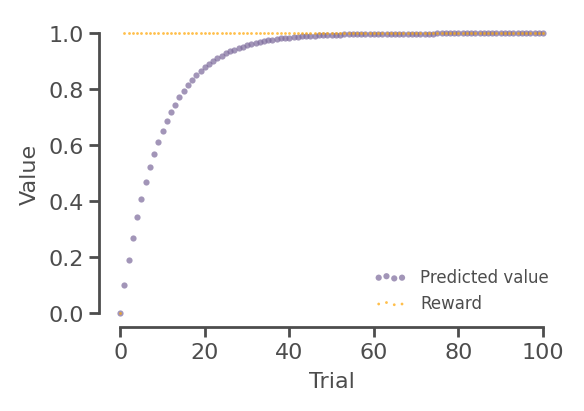

In [4]:
# Set your learning rate and reward
alpha = 0.1
R = 1

# Create the model
RW = RescorlaWagner(alpha=alpha)

# Run the model
for trial in range(100):
    RW.learn(R=R)

# Plot the results
ax = RW.plot()

> 📝 **Exercise 1.3**
>
> Plot the theoretical solution you derived earlier onto the `ax` and see if it fits.

In [5]:
# Your code goes here

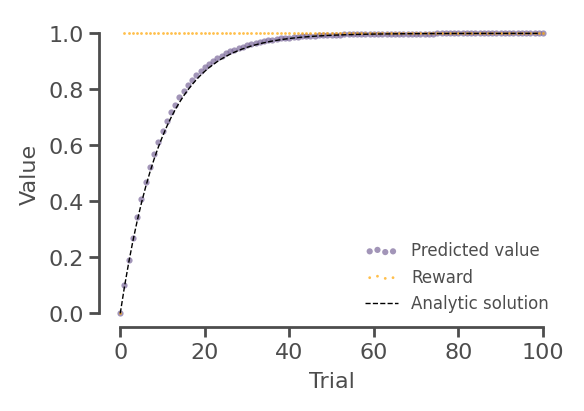

In [6]:
#@title Click to see solution {display-mode: "form" }
t_range = np.arange(100)
V = R * (1 - np.exp(-t_range*alpha))
ax.plot(t_range, V, label='Analytic solution', linewidth=0.5, color='k', linestyle='--')
ax.legend()
ax.figure

> 📝 **Exercise 1.4**
> 
> 1. **Acquisition:** Repeat the above experiment with a lower and a higher learning rate. What do you observe?
> 2. **Extinction:** Repeat the above but this time reward is given only for the first 50 trials, then the reward is set to zero. What do you observe?


In [7]:
# Your code for low learning rate acquisition goes here

Text(0.5, 1.0, 'Higher learning rate')

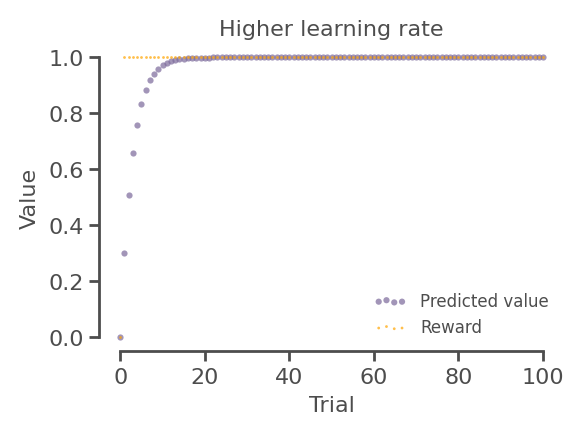

In [8]:
#@title Click to see solution {display-mode: "form" }
# Set your learning rate and reward
alpha = 0.3
R = 1

# Create the model
RW = RescorlaWagner(alpha=alpha)

# Run the model
for trial in range(100):
    RW.learn(R=R)

# Plot the results
ax = RW.plot()
ax.set_title("Higher learning rate")

In [9]:
# Your code for high learning rate acquisition goes here

Text(0.5, 1.0, 'Lower learning rate')

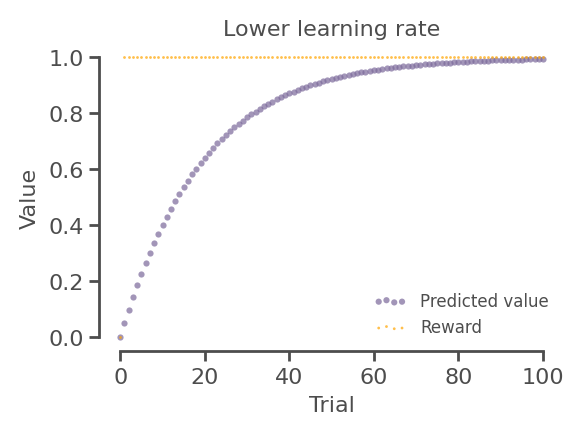

In [10]:
#@title Click to see solution {display-mode: "form" }
# Set your learning rate and reward
alpha = 0.05
R = 1

# Create the model
RW = RescorlaWagner(alpha=alpha)

# Run the model
for trial in range(100):
    RW.learn(R=R)

# Plot the results
ax = RW.plot()
ax.set_title("Lower learning rate")

In [11]:
# Your code for extinction goes here

Text(0.5, 1.0, 'Extinction experiment')

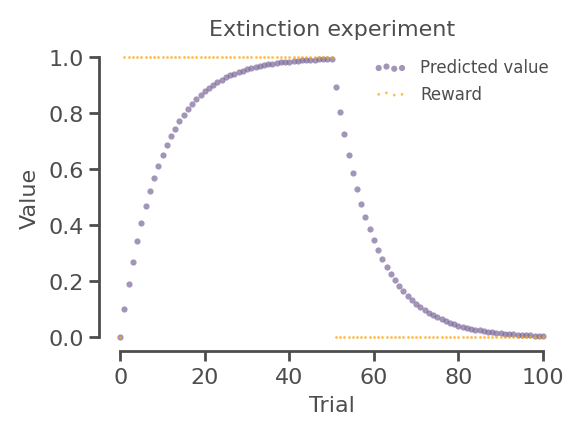

In [12]:
#@title Click to see solution {display-mode: "form" }
# Set your learning rate and reward
alpha = 0.1

# Create the model
RW = RescorlaWagner(alpha=alpha)

# Run the model
for trial in range(50):
    RW.learn(R=1)
for trial in range(50): #remove the reward
    RW.learn(R=0)

# Plot the results
ax = RW.plot()
ax.set_title("Extinction experiment")

### **1.3. Rescorla-Wagner with multiple unconditioned stimuli**

It's easy to extend the Rescorla-Wagner model to multiple stimuli:

* Multiple stimuli are represented by a vectors, e.g.:  
    * Stimulus A: $\mathbf{s} = [1, 0]$ means there are 2 stimuli, only the first of which was present on this particular trial. 
    * Stimulus B: $\mathbf{s} = [0, 1]$ means only the second stimulus was present.
    * Stimulus A & B: $\mathbf{s} = [1, 1]$ means both stimuli were present.
* A vector of association "weights", $\mathbf{w}$, denotes the strength of the association between each stimulus and the unconditioned response (i.e. the value of each stimulus). 
    * $\mathbf{w} = [w_1, w_2]$.
* The total value of the stimuli is the sum of the values of each stimulus present on a given trial: 
$$ \hat{V} = \mathbf{s} \cdot \mathbf{w} $$

The full Rescorla-Wagner model is then:
$$\mathbf{w} = \mathbf{w} + \alpha \big(R - \hat{V}\big) \cdot \mathbf{s}$$

> 📝 **Exercise 1.5**
>
> Reason why $\mathbf{s}$ now appears in the learning rule.

> 📝 **Exercise 1.6**
> 
> As before, complete the `def learn(self, R, S):` function to implement the Rescorla-Wagner learning rule for multiple stimuli.

In [13]:
class RescorlaWagner_multistim(BaseRescorlaWagner):
    def __init__(self, n_stimuli=2, alpha=0.1, initial_value=0): 
        self.W = np.zeros(n_stimuli)
        super().__init__(n_stimuli=n_stimuli, alpha=alpha)

    def learn(self, S, R):
        raise NotImplementedError("You need to implement this method")
        # V = ????  # calculate the value of the stimuli
        # error = # ???? # calculate the error
        # self.W += # ???? # update the weights

        # store the history
        # self.W_history = np.vstack([self.W_history, self.W])
        # self.R_history.append(R)
        # self.V_history.append(S @ self.W)
        # self.S_history.append(S)


In [14]:
#@title Click to see solution {display-mode: "form" }
def learn(self, S, R):
    V = S @ self.W # calculate the value of the stimuli
    error = R - V # calculate the error
    self.W += alpha * S * error # update the weights

    # store the history
    self.W_history.append(self.W.copy())
    self.R_history.append(R)
    self.V_history.append(S @ self.W)
    self.S_history.append(S)

# Set the learn method to the function we just defined.
RescorlaWagner_multistim.learn = learn

**Exercise 1.7**:
1. With your partner implement these four experiments in the Rescorla-Wagner model:
    1. **Blocking**
        * A single stimulus is paired with the US (A --> R), then a compound stimulus is paired with the US (AB --> R). What happens?
    2. **Overshadowing**
        * Two stimuli are paired with a reward (AB --> R) but one is much more salient than the other, e.g. $\vec{S} = [1, 0.1]$.
    3. **Overexpectation**
        * Two stimuli are seperately paired with the US (A --> R, B --> R), then the compound stimulus is presented (AB --> ?). What happens?
    4. **Conditioned Inhibition**
        * A single stimulus is paired with the US (A --> R) then a second stimulus is added and the reward is removed. (AB --> _). What do you observe?

In [15]:
# Your code for the blocking experiment goes here

In [16]:
#@title Double click to see solution {display-mode: "form" }
RW = RescorlaWagner_multistim(n_stimuli=2, alpha=0.1)
for i in range(50):
    RW.learn(S=np.array([1,0]), R=1)
for i in range(50):
    RW.learn(S=np.array([1,1]), R=1)

[<Axes: ylabel='Stimuli, s'>,
 <Axes: ylabel='Weights, w'>,
 <Axes: xlabel='Trial, t', ylabel='Reward, R'>]

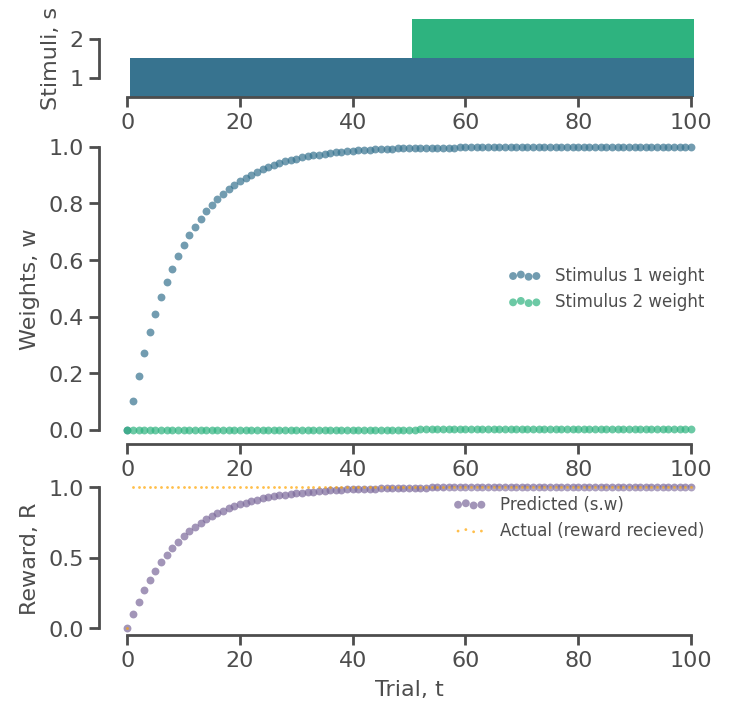

In [17]:
RW.plot()

Let's break down this plot: 

* The **top** plot shows the stimuli which were present on each trial. Their transparency denotes their strength. 
* The **middle** plot shows the association weights of the stimuli.
* The **bottom** plot shows the total value of the presented stimuli $V = \mathbf{s}\cdot\mathbf{w}$ along with the reward recieved on each trial.


In [18]:
# Your code for the overshadowing experiment goes here

Text(0.5, 1.0, 'Overshadowing')

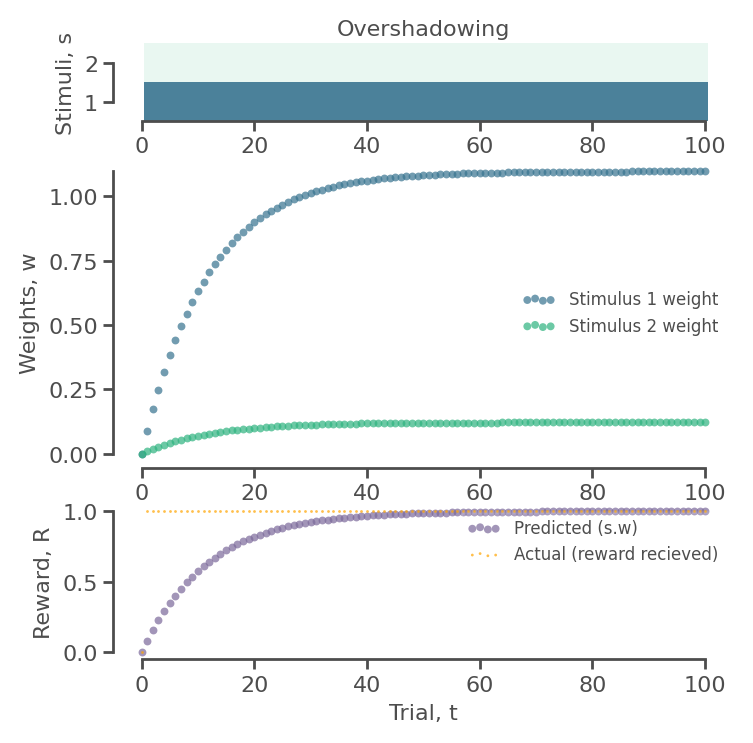

In [19]:
#@title Double click to see solution {display-mode: "form" }
RW = RescorlaWagner_multistim(n_stimuli=2)
for i in range(100):
    RW.learn(S=np.array([0.9, 0.1]), R=1)
ax = RW.plot()
ax[0].set_title("Overshadowing")

In [20]:
# Your code for the overexpectation experiment goes here

Text(0.5, 1.0, 'Overexpectation')

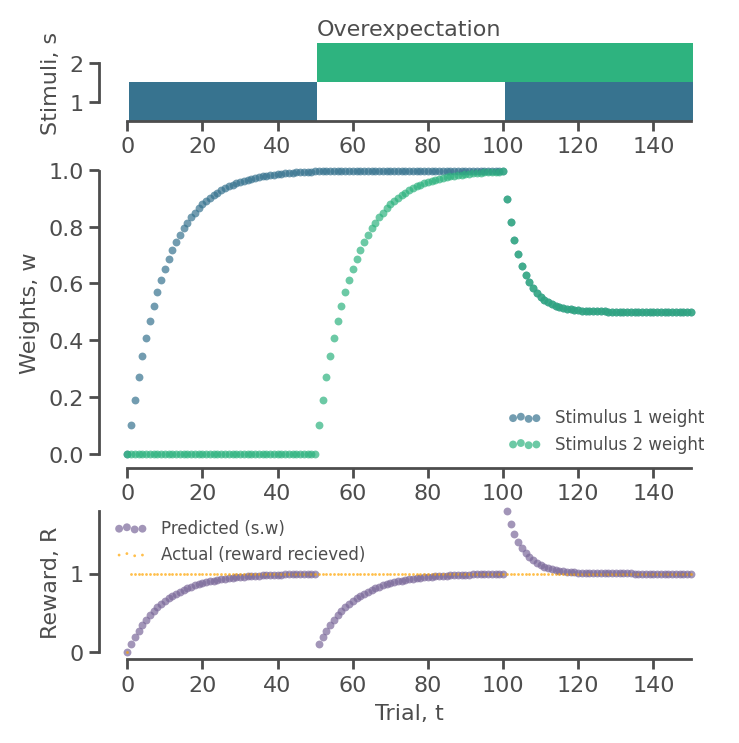

In [21]:
#@title Double click to see solution {display-mode: "form" }
RW = RescorlaWagner_multistim(n_stimuli=2)
for i in range(50):
    RW.learn(S=np.array([1, 0]), R=1)
for i in range(50):
    RW.learn(S=np.array([0, 1]), R=1)
for i in range(50):
    RW.learn(S=np.array([1, 1]), R=1)
ax = RW.plot()
ax[0].set_title("Overexpectation")

In [22]:
# Your code for the inhibition experiment goes here

Text(0.5, 1.0, 'Inhibition')

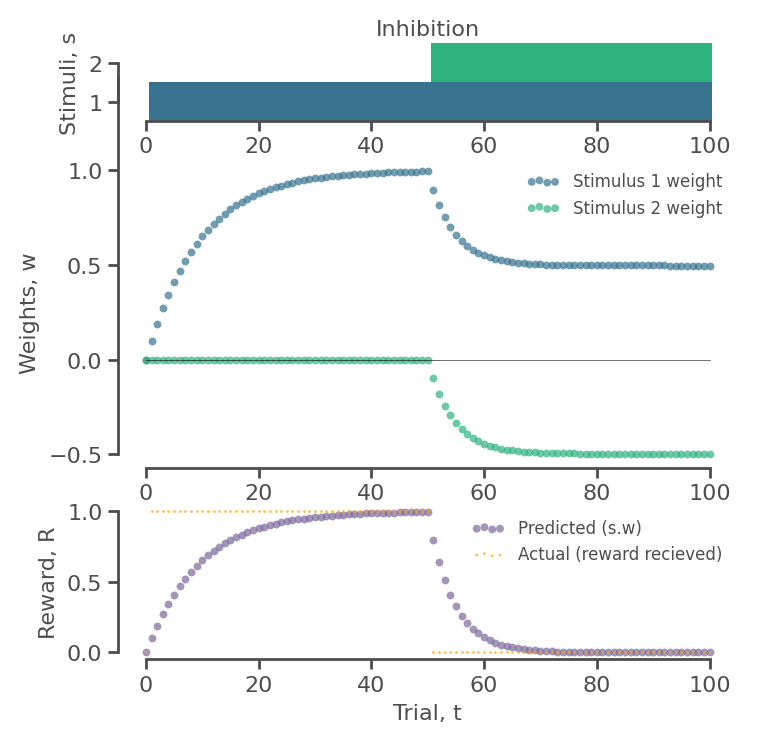

In [23]:
#@title Double click to see solution {display-mode: "form" }
RW = RescorlaWagner_multistim(n_stimuli=2)
for i in range(50):
    RW.learn(S=np.array([1, 0]), R=1)
for i in range(50):
    RW.learn(S=np.array([1, 1]), R=0)
ax = RW.plot()
ax[0].set_title("Inhibition")

> 📝 **Exercise 1.8**
>
> 1. Starting from the inhibition experiment above, extend it so that the reward prediction goes negative.
> 2. Simulate a conditioning experiment with three stimuli, where the first two are paired with the US and the third is not. What do you observe?

In [24]:
#Your code for the negative reward prediction experiment goes here

Text(0.5, 1.0, 'Negative reward prediction')

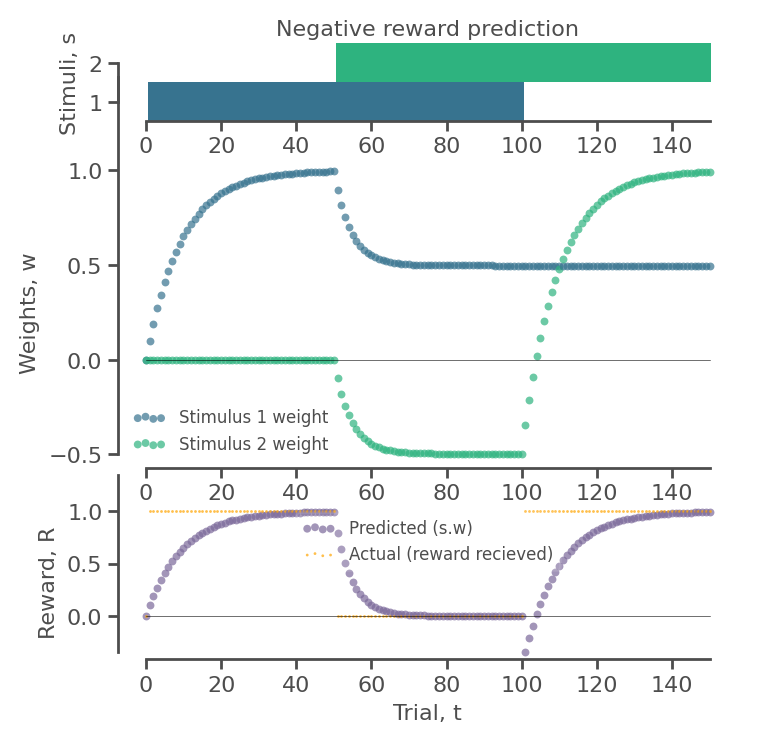

In [25]:
#@title Double click to see solution {display-mode: "form" }
RW = RescorlaWagner_multistim(n_stimuli=2)
for i in range(50):
    RW.learn(S=np.array([1, 0]), R=1)
for i in range(50):
    RW.learn(S=np.array([1, 1]), R=0)
for i in range(50):
    RW.learn(S=np.array([0, 1]), R=1)
ax = RW.plot()
ax[0].set_title("Negative reward prediction")

---
## **2. Temporal difference learning** <a name="td"></a>

One limitation of the Rescorla-Wagner model is that it doesn't take into account the temporal structure of the environment. Associations are made between stimuli _now_ and rewards _now_. In reality, rewards are often delayed.

Temporal difference (TD) learning takes into account the temporal structure of the environment. As you learnt in today's lecture the core idea is thatthe "value" of a state is based not only on the reward recieved _now_ but on all the rewards that _will be_ recieved in the future.

$$V(S_t) = \mathbb{E} \big[ \underbrace{R_t + \gamma R_{t+1} + \gamma^2 R_{t+2} + \ldots}_{G_t = \textrm{``return'' from state $_{S_t}$}}\big]$$

To formalise notation, we'll define $\hat{V}(S_t)$ as _our current estimate of the value of a state_ $V(S_t)$. The goal of learning is to to refine $\hat{V}(S_t)$ to be as close as possible to $V(S_t)$.

> 📝 **Exercise 2.1**
>
> By considering the following loss function: 
> $$L_t = \big[ \hat{V}(S_t) - V(S_t) \big]^2$$
> show, by gradient descent in $\hat{V}(S_{t})$, that the optimal update rule for $\hat{V}(S_t)$ is:
> $$\hat{V}(S_t) \leftarrow \hat{V}(S_t) + \alpha \big[ V(S_t) - \hat{V}(S_t) \big]$$

### **2.1 Monte-Carlo learning**
One way to estimate the value of a state is to wait until the end of each episode, collecting all the rewards that were recieved along the way and calculate the single-episode return $G_t$. Since the _expectation_ of $G_t$ is equal to $V(S_t)$ this is equivalent to _stochastic gradient descent_ of the loss function and is called Monte-Carlo learning.

$$ \hat{V}(S_t) \leftarrow \hat{V}(S_t) + \alpha  \big[ G_t - \hat{V}(S_t) \big] $$

Although in theory this does work, in practice, Monte-Carlo learning is often infeasible because it requires waiting until the end of each episode to update the value of each state. This turns out to be quite a serious limitation in real-world applications - imagine waiting until the end of a game of chess to update the value of each state! Or worse, some environments don't have a clearly defined end such as the game of life we're all currently playing. 

This is where TD learning comes in...


### **2.2 TD-Learning**
The key idea behind TD-learning is to estimate the value of a state by bootstrapping from the value of the next state. 

> 📝 **Exercise 2.2**
>
> 1. Show that the value of a state can be written as the sum of the reward recieved at that state and the value of the next state. i.e.
> $$V(S_t) = \mathbb{E} [R_t + \gamma V(S_{t+1})]. $$

This is called the _Bellman equation_ and is the basis of TD-learning. Its encodes a _very_ important idea: 

**Bellman Equation:  The future value of a state now is equal to the reward recieved now plus the value of the next state (discounted a little bit).**

But wait! How do we know the value of the next state? We don't! That's why we're learning! So we'll use our current estimate of the value of the next state, $\hat{V}(S_{t+1})$ as a _proxy_.

$$V(S_t) = \mathbb{E} [\color{red}{\underbrace{R_t + \gamma V(S_{t+1})}_{\textrm{I don't know this}}} \color{d}{}] \approx  \mathbb{E}[\color{green}{\underbrace{R_t + \gamma \hat{V}(S_{t+1})}_{\textrm{I do know this}}}\color{d}{}] $$

This gives us the TD-learning update rule:

$$\hat{V}(S_t) \leftarrow \hat{V}(S_t) + \alpha \big[\underbrace{R_t + \gamma \hat{V}(S_{t+1}) - \hat{V}(S_t)}_{\delta_t = \textrm{``TD-error''}} \big]$$

> 📝 **Exercise 2.3**
>
> 1. Implement the TD-learning update rule in the `def learn(self, R, S, S_next, alpha):` function in the `TDLearner` class below.
> 

In [9]:
class TDLearner(BaseTDLearner):
    def __init__(self, gamma=0.5, alpha=0.1, n_states=10):
        super().__init__(gamma=gamma, alpha=alpha, n_states=n_states)

    def perform_episode(self, 
                        states : np.ndarray, 
                        rewards : np.ndarray,):

        T_episode = len(states) + 1 # get the length of the episode (including the initial None state)

        # Insert an unrewarded "None" state at the beginning to indicate the start of an episode
        rewards = np.insert(rewards, 0, 0)
        states = np.insert(states.astype(object), [0, len(states)], [None, None])

        # Loop over the states and learn from each transition
        TD_errors = np.empty(T_episode) # store the TD errors
        for i in range(T_episode):
            # Learn from this transition
            TD_errors[i] = self.learn(states[i], states[i+1], rewards[i])
        
        # Save to history 
        self.V_history.append(self.V.copy())
        self.S_history.append(states[:T_episode])
        self.TD_history.append(TD_errors)
        self.R_history.append(rewards)
        
    def learn(self, S, S_next, R):
        raise NotImplementedError("You need to implement this method")
        # Get's the value of the current and next state
        # V = self.V[S] if S is not None else 0
        # V_next = self.V[S_next] if S_next is not None else 0
        
        # Calculates the TD error (hint remember to use self.gamma
        # TD_error = # ???

        # Updates the value of the current state
        # if S is not None:
            # self.V[S] = # ???

        #  return TD_error

In [10]:
#@title Click to see solution {display-mode: "form" }
def learn(self, S, S_next, R):
    # Get's the value of the current and next state
    V = self.V[S] if S is not None else 0
    V_next = self.V[S_next] if S_next is not None else 0
    
    # Calculates the TD error 
    TD_error = R + self.gamma * V_next - V

    # Updates the value of the current state
    if S is not None:
        self.V[S] = self.V[S] + self.alpha * TD_error

    return TD_error

TDLearner.learn = learn

### **2.3 Training a TD-Learner on a sequence of states** 

Now we're going to train the TD learner in a simple environment. 

States are represented by integers, e.g. $S_t = 0$ means the agent is in state 0. And states are connected in a sequence, e.g. $S_t = 0 \rightarrow S_{t+1} = 1 \rightarrow S_{t+2} = 2 \ldots$.

At the final state, the agent recieves a reward of $R = 1$ and the episode ends.

To run this episode we'll use the `perform_episode` function which takes a list of states and list of rewards and loops through them, saving the results as it goes: 

```python
TD.perform_episode(
    states  = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
    rewards = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
)
```

In [11]:
# Set some parameters 
n_episodes = 40
gamma = 0.95
alpha = 0.8 # for now use a high learning rate
n_states = 10

# Initialize the TD learner
TD = TDLearner(gamma=gamma, n_states=n_states, alpha=alpha)

# Run the experiment
for episode in range(n_episodes):
    TD.perform_episode(
        states=np.arange(n_states), 
        rewards=np.eye(n_states)[n_states-1],  ) 

for episode in range(n_episodes):
    TD.perform_episode(
        states=np.arange(n_states), 
        rewards=np.zeros(n_states),  ) 

In [12]:
anim = TD.animate_plot()
HTML(anim.to_html5_video())

> 📝 **Exercise 2.4**
> 
> With your partner, answer the following questions:
> 1. After learning has converged, what is the value of state 0? 
> 2. Approximately how fast does the value bump move backwards? How does this relate to the notion of one-step bootstrapping. 
> 3. Why does a residual TD-error accumulate at the start? Understanding this is important for understanding TD-learning.

#@title Double click to see solution {display-mode: "form" }
> 📝 **Exercise 2.4 SOLUTIONS**
>
> 1. State 9 has value $V = R$, state 8 has value $V = 0 + \gamma * R = \gamma R$, state 7 has value $V = 0 + \gamma^2 R$, etc. So state 0 has value $V = \gamma^9 R$. So if $R=1$ and $\gamma = 0.9$ then $V = 0.9^9 = 0.387420489$.
> 2. Suppose $\alpha = 1$ and $\gamma$ is close to one. The first time the agent recieves the reward at state 9 it's value will be updated to $V = 1$ and no further learning will occur on this state (its TD error will be zero). On the next trial the value of state 8 will be updated due to the a TD error because the new value of upcoming stae 9 wasn't predicted. Thus, the bump moves backwards at approximately a rate of **one-step-each-trial**.
> 3. The residual TD-error at the start is because the first state is never predictable. Pavlov's dog may be able to associate the bell with the food, but it can't predict the bell so hearing the bell will always come as a positive surprise (aka. a positive TD-error).

> 📝 **Exercise 2.5**
>
> Try the following experiments and discuss the results: 
>     1. Decrease the learning rate.
>     2. Increase the discount factor.
>     3. Increase the number of states in the sequence.
>     4. Add noise to the rewards.

> 📝 **Exercise 2.6**
>
> 1. What would happen to the TD error if a small positive reward is given at the end (as we just simulated) and then, after learning has converged, the reward is removed? _Hint: think about what happens in the brain, and why_.

---
## **3. Q-Values and Policy Improvement** <a name="q"></a>

So far we have only considered environments where there is no choice. The agent is simply moving through a sequence of states. In the real world agents have choices (called _actions_) and the value of a state is not just the value of the state itself but the value of the state _and the action taken in that state_.

We need to introduce the formal concept of a _policy_ which is a function that maps states to actions. The value of a state under a policy is the expected return (i.e. discounted sum of all future rewards) from that state under that policy. Policies are often denoted by $\pi$, they are functions which map states to actions

$$ \pi : S \rightarrow A $$

In an environment with a policy, states, actions and rewards progress as follows:

$$ S_0 \xrightarrow{A_0} R_1, S_1 \xrightarrow{A_1} R_2, S_2 \xrightarrow{A_2} R_3, S_3 \xrightarrow{A_3} R_4, S_4 \xrightarrow{A_4} \ldots $$

The _action_ the agent took at each state determines the state the agent ends up in next which may (or may not) come with a reward.

### **3.1 Q-Values**

The "value'' of a state now depends not just on the state but on the action taken in that state and the policy that was followed thereafter. 

Q-values represent a natural generalisation of the state value of a state-action pair under a policy: 

$$ Q_{\pi}(s, a) = \mathbb{E}_{\pi} \big[ R_t + \gamma R_{t+1} + \gamma^2 R_{t+2} + \ldots \big| S_t = s, A_t = a \big] $$

In plain English this say: "$Q_{\pi}(s, a)$ is the expected return from taking action $a$ in state $s$ and then following policy $\pi$.". Note the expectation is over $\pi$ because the policy determines the future actions, states and rewards. The policy (which actions are taken in which states) and the environment (which states and rewards are reached from which states) could both be stochastic.

### **3.2 Policy Improvement: Finding the _best_ policy**

The goal of reinforcement learning is to find the _best_ policy i.e. the policy that maximises the expected return from every state!


In fact the code learning rule is so similiar w can hijack the exact same code from the TD-learner and use it to learn Q-values, all we'll do different is _pretend_ that each state-action pair is a "state". We can do this by uniquely labelling each state-action pair with a single integer.

$$ (x=0, y=0, action="North") \rightarrow 0, (x=0, y=0, action="East") \rightarrow 1, (x=0, y=0, action="South") \rightarrow 2, (x=0, y=0, action="West") \rightarrow 3, \ldots $$

In [67]:
import xarray as xr 
class MiniGrid(TDLearner):
    def __init__(
        self,
        grid : np.ndarray,
        init_agent_pos : tuple = (10,10),
        max_steps = 100,
    ):
        self.grid = grid
        self.width = grid.shape[1]
        self.height = grid.shape[0]
        self.x_coords = np.arange(self.width)
        self.y_coords = np.arange(self.height)[::-1]
        self.grid = xr.DataArray(grid, dims=("y", "x"), coords={"y": self.y_coords, "x": self.x_coords})
        self.agent_pos = init_agent_pos
        self.agent_direction = 0
        self.max_steps = max_steps

        self.episode_count = 0 
        self.episode_history = {}

        # self.state_action_index is an array such that self.state_action_index[x,y,a] returns the _unique_ index of the state-action pair at position (x,y), action a.
        a = np.array([0,1,2,3]) # {0: North, 1: East, 2: South, 3: West}
        self.state_action_shapes = (self.width, self.height, 4)
        self.n_states = self.width * self.height * len(a)
        self.state_action_index = np.arange(self.n_states).reshape(self.state_action_shapes)
        
    def plot_env(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(0.1*self.width, 0.1*self.height))

        # grid = np.where(self.grid == 2, 0, self.grid) # remove the reward from the grid and plot it seperately 
        grid = ax.imshow(grid, cmap="Greys", origin='upper', alpha=grid.astype(float), zorder=20, extent=[-0.5, self.width+0.5, -0.5, self.height+0.5])

        # reward_position = np.argwhere(self.grid.values == 2)[0]
        # reward = plt.Circle(reward_position, 0.4, color='orange')
        # ax.add_patch(reward)

        return ax 

    def plot_agent(self, agent_pos, agent_direction, ax, **kwargs):
        alpha = kwargs.get("alpha", 1)
        color = kwargs.get("color", plt.cm.viridis(0))
        size_scaler = kwargs.get("size_scaler", 1)
        # Define the base triangle vertices relative to origin
        base_triangle = np.array([[0.1, 0.1], [0.9, 0.1], [0.5, 0.9]])
        center = np.array([0.5,0.5])
        translated_triangle = base_triangle - center
        scaled_triangle = translated_triangle * size_scaler
        # Define the rotation matrix based on direction
        if agent_direction==0: angle=0  # North
        elif agent_direction==1: angle=3*np.pi/2 # East
        elif agent_direction==2: angle=np.pi # South
        elif agent_direction==3: angle=np.pi/2 # West
        rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], 
                                    [np.sin(angle), np.cos(angle)]])
        # Rotate the triangle
        rotated_triangle = np.dot(scaled_triangle, rotation_matrix.T)   
        # Translate the triangle to the agent position
        translated_triangle = rotated_triangle + np.array(agent_pos) + 0.5
        # Plot the triangle
        triangle = plt.Polygon(translated_triangle, color=color, zorder=10, alpha=alpha, linewidth=0)
        ax.add_patch(triangle)
        return ax
    
    def perform_episode(self,Q_values,epsilon=0.1):
        episode_step = 0
        episode_end = False

        Q_values = Q_values.reshape(self.state_action_shapes)  
        
        # Some lists to store episode data
        state_action_indices = [self.get_state_action_index(pos=self.agent_pos, action=self.agent_direction)]
        rewards_recieved = [0] 
        posiions_visited = [self.agent_pos]
        actions_taken = [self.agent_direction]

        while not episode_end:
            if np.random.rand() < epsilon:
                action = np.random.randint(4)
            else:
                action = np.argmax(Q_values[self.agent_pos[0], self.agent_pos[1], :])

            pos_next, reward, episode_end = self.step(action)
            state_action_index = self.get_state_action_index(pos=self.agent_pos, action=action)
            episode_step += 1
            if episode_step > self.max_steps:
                episode_end = True
            
            # Append step data
            posiions_visited.append(self.agent_pos)
            actions_taken.append(action)
            state_action_indices.append(state_action_index)
            rewards_recieved.append(reward)

        self.episode_history[self.episode_count] = {
            "positions": posiions_visited,
            "actions": actions_taken,
            "rewards": rewards_recieved,
            "state_action_indices": state_action_indices
        }
        
        self.episode_count += 1

        return self.episode_history[self.episode_count-1]

    def step(self, action):
        if action == 0: delta = (0,1) # North
        elif action == 1: delta = (1,0) # East
        elif action == 2: delta = (0,-1) # South
        elif action == 3: delta = (-1,0) # West
        proposed_next_pos = np.array(self.agent_pos) + np.array(delta)
        is_wall = self.grid.sel(x=proposed_next_pos[0], y=proposed_next_pos[1]) == 1
        if not is_wall:
            self.agent_pos = tuple(proposed_next_pos)
        reward = 0 
        is_reward = self.grid.sel(x=proposed_next_pos[0], y=proposed_next_pos[1]) == 2
        if is_reward:
            reward = 1
        episode_end = False
        if is_reward:
            episode_end = True

        return self.agent_pos, reward, episode_end

    def get_state_action_index(self, pos, action):
        return self.state_action_index[pos[0], pos[1], action]

    def reset(self):
        # random start position
        is_illegal_position = True
        while is_illegal_position:
            self.agent_pos = (np.random.randint(self.width), np.random.randint(self.height))
            is_illegal_position = self.grid.sel(x=self.agent_pos[0], y=self.agent_pos[1]) == 1
        self.agent_direction = np.random.randint(4)

    
    def render(self):
        ax = self.plot_env()
        ax = self.plot_agent(ax)
        plt.show()

    def plot_episode(self, episode_count=0):

        episode_data = self.episode_history[episode_count]
        positions = episode_data["positions"]
        actions = episode_data["actions"]
        rewards = episode_data["rewards"]

        ax = self.plot_env()
        for i in range(len(positions)):
            episode_frac = i/len(positions)
            ax = self.plot_agent(agent_pos=positions[i], agent_direction=actions[i], ax=ax, alpha=episode_frac, color = plt.cm.viridis(1-episode_frac), size_scaler=episode_frac)
        
        return

    def plot_Q_values(self, Q_values):
        Q_values = Q_values.reshape(self.state_action_shapes)
        fig, ax = plt.subplots(1,4, figsize=(20,5))
        for i in range(4):
            ax[i] = self.plot_env(ax=ax[i])
            ax[i].imshow(Q_values[:,:,i], cmap="viridis", extent=[0, self.width, 0, self.height], alpha=0.5)
            ax[i].set_title(f"Action {i}")
        plt.show()


In [68]:
mg.grid == 2
# find where dataarary mg.gird is 2 in data  coords
reward_position = np.argwhere(mg.grid.values == 2)[0]

In [69]:
reward_position

array([14, 17])

In [70]:
grid = np.array( # 0 = empty, 1 = wall, 2 = reward
    [
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    ]
)
mg = MiniGrid(
    grid = grid 
)

td = TDLearner(gamma=0.9, alpha=0.1, n_states=mg.n_states)
td.V = np.random.uniform(low=0,high=0.01, size=mg.n_states)

In [71]:
from tqdm import tqdm
for i in tqdm(range(1000)):
    episode = mg.perform_episode(Q_values = td.V)
    mg.reset()
    td.perform_episode(states=np.array(episode["state_action_indices"]), rewards=np.array(episode["rewards"]))

100%|██████████| 1000/1000 [00:17<00:00, 56.82it/s]


ValueError: Dimensions {None} do not exist. Expected one or more of ('y', 'x')

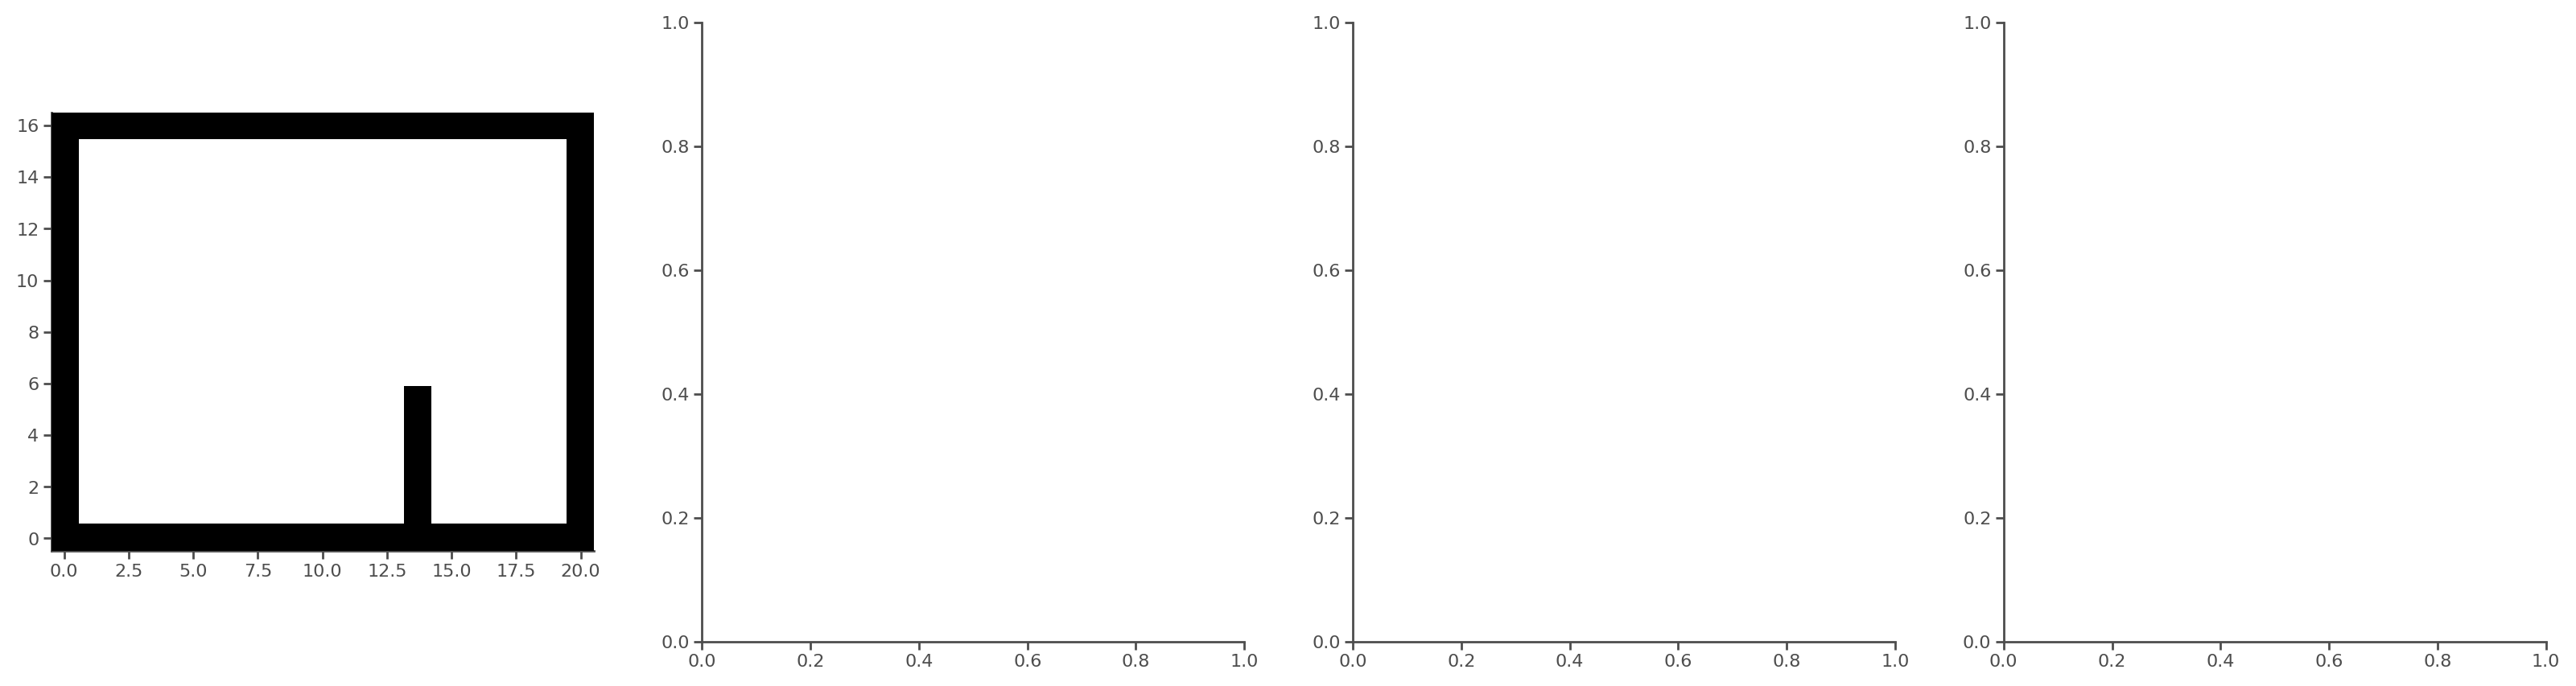

In [63]:
mg.plot_Q_values(td.V)